In [1]:
import os
import numpy as np
import pandas as pd
import cld3
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from gensim.models import FastText
from gensim.models.word2vec import Word2Vec
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from tqdm import tqdm

In [2]:
nltk.download('stopwords')
tokenizer = nltk.RegexpTokenizer(r"\w+")
stopw_words = { w:True for w in stopwords.words('portuguese') }

[nltk_data] Downloading package stopwords to /home/welton/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
path_df = "data/articles.csv"
df = pd.read_csv(path_df)
df.head()

,title,text,date,category,subcategory,link
0,"Lula diz que está 'lascado', mas que ainda tem...",Com a possibilidade de uma condenação impedir ...,2017-09-10,poder,NaN,http://www1.folha.uol.com.br/poder/2017/10/192...
1,"'Decidi ser escrava das mulheres que sofrem', ...","Para Oumou Sangaré, cantora e ativista malines...",2017-09-10,ilustrada,NaN,http://www1.folha.uol.com.br/ilustrada/2017/10...
2,Três reportagens da Folha ganham Prêmio Petrob...,Três reportagens da Folha foram vencedoras do ...,2017-09-10,poder,NaN,http://www1.folha.uol.com.br/poder/2017/10/192...
3,Filme 'Star Wars: Os Últimos Jedi' ganha trail...,A Disney divulgou na noite desta segunda-feira...,2017-09-10,ilustrada,NaN,http://www1.folha.uol.com.br/ilustrada/2017/10...
4,CBSS inicia acordos com fintechs e quer 30% do...,"O CBSS, banco da holding Elopar dos sócios Bra...",2017-09-10,mercado,NaN,http://www1.folha.uol.com.br/mercado/2017/10/1...


<AxesSubplot:>

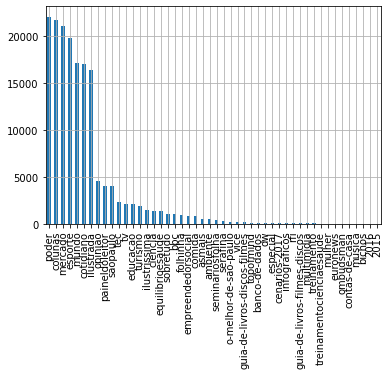

In [4]:
df.category.value_counts().plot(kind='bar', grid=True)

In [4]:
def clean_text(text, tokenizer, stop_words):
    tokens = [ word for word in tokenizer.tokenize(text.lower()) if word not in stop_words ]
    return " ".join(tokens)

df = df[df.text.notna()]
df["text_clean"] = df.text.apply(lambda text: clean_text(text, tokenizer, stopw_words))
df["tokens"] = df.text_clean.apply(lambda text: text.split(' '))

In [9]:
def train_model(texts):

  model = FastText(vector_size=100, window=10, min_count=3, alpha=0.025, min_alpha=0.025, workers=10, sg=1)
  model.build_vocab(texts)
  for epoch in tqdm(range(10)):
    model.train(texts, total_examples=model.corpus_count, epochs=1)
    model.alpha -= 0.002
    model.min_alpha = model.alpha
  return model

In [52]:
model_df = "models/fasttext_sg"
if not os.path.exists(model_df):
  print("Training a new model...")
  model = train_model(df.tokens.values)
  model.save(model_df)
else:
  print("Loading model...")
  model = FastText.load(model_df)

Training a new model...


100%|██████████| 10/10 [31:26<00:00, 188.70s/it]


# Apply attention here

D1: Beijing é a capital da China --> Beijing capital China

D2: A China importa carne da Rússia --> China importa carne Rússia

In [ ]:
docs = [["beijing", "capital", "china"], ["china", "importa", "carne" "russia"], ["brasil", "ganha", "jogo", "china"]]

dict_list = []
for doc in docs:
  doc_vec = np.zeros(100)
  len_doc = len(doc)
  weights = np.zeros((len_doc, len_doc))
  ## Attention
  line = 0
  for word in doc:
    col = 0
    for word2 in doc:
      weights[line][col] = np.dot(model.wv[word], model.wv[word2])
      col += 1
    line += 1
  ## Softmax
  weights = np.array(weights)
  attention_words = {}
  ## Para os pesos de cada palavra.
  for line in weights:
    soft_w = []
    ## Para cada palavra.
    for position in line:
      soft_w.append(np.exp(position)/sum(np.exp(line)))
    ## Fazendo a adição do contexto.
    pos = 0
    for sw in soft_w:
      attention_words[doc[pos]] = model.wv[doc[pos]] * sw
      pos += 1
  dict_list.append(attention_words)

In [11]:
# Get embeddings for documents.
def get_doc_emb(tokens, model):
  
  return np.mean([ model.wv[word] for word in tokens if word in model.wv ], axis=0)

# Get embeddings for all documents.
def get_embeddings(sentences, model):

  return np.array([ get_doc_emb(sent, model) for sent in sentences])

In [39]:
#df["embs"] = get_embeddings(df.text_clean.values, model)
op_tokens = df[ df.category == "mercado" ].text_clean.values
ed_tokens = df[ df.category == "esporte" ].text_clean.values

In [40]:
op_embs = get_embeddings(op_tokens, model)
ed_embs = get_embeddings(ed_tokens, model)

In [41]:
from sklearn import preprocessing
y = list(df[ df.category == "mercado" ].category.values)
y += list(df[ df.category == "esporte" ].category.values)
le = preprocessing.LabelEncoder()
le.fit(y)
y = le.transform(y)
y

array([1, 1, 1, ..., 0, 0, 0])

In [42]:
from sklearn.model_selection import train_test_split

In [43]:
op_embs.shape, ed_embs.shape, y.shape

((20970, 100), (19730, 100), (40700,))

In [44]:
X = np.vstack([op_embs, ed_embs])

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=True)

In [46]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((30525, 100), (30525,), (10175, 100), (10175,))

In [47]:
clf = LogisticRegression(max_iter=2000, n_jobs=-1)
clf.fit(X_train, y_train)

LogisticRegression(max_iter=2000, n_jobs=-1)

In [48]:
y_pred = clf.predict(X_test)

In [49]:
f1_score(y_test, y_pred)

0.8488415545590433

In [50]:
set(y_test), set(y_pred)

({0, 1}, {0, 1})

In [54]:
model.wv.most_similar(positive=["dilma"], topn=20)

[('adilma', 0.942486047744751),
 ('dilmas', 0.8968988060951233),
 ('foradilma', 0.8923149108886719),
 ('antidilma', 0.8757702112197876),
 ('dilmo', 0.875711977481842),
 ('diiilma', 0.8557265400886536),
 ('diiiilma', 0.8482351303100586),
 ('tramondilma', 0.8446165919303894),
 ('dilmar', 0.8410153388977051),
 ('ilma', 0.8320500254631042),
 ('bandilma', 0.8042155504226685),
 ('dilmadamulher', 0.7958760857582092),
 ('dilmês', 0.762985110282898),
 ('dilmiana', 0.7607585191726685),
 ('hilma', 0.7531442642211914),
 ('dilmiano', 0.7508584856987),
 ('dilmista', 0.7387287616729736),
 ('dilminha', 0.7371273040771484),
 ('dilmexit', 0.7035101652145386),
 ('dilú', 0.6893172860145569)]